In [1]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(janitor)
library(ggrepel)
library(data.table)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year




In [2]:
#Load in the CRISPR screening data
setwd("../data")
achilles.22q1 = fread("22q1_Achilles_gene_effect.csv", sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1)) %>%
rename("sample" = 1)

In [6]:
#Load in the gene block matrix that lists the ancestry for all genes and for all cell lines
setwd("../data")
gene.block.matrix = fread("gene.block.matrix.txt", sep = "\t")
row.names(gene.block.matrix) = NULL

#Format gene.block.matrix so that it is ready for our analysis
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample))

Warning message in fread("gene.block.matrix.txt", sep = "\t"):
“Detected 1000 column names but the data has 1001 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [7]:
#Filter both datasets so that they share a common set of samples
intersecting.samples = intersect(achilles.22q1$sample, formatted.gene.block.matrix$sample)
intersecting.genes = intersect(colnames(achilles.22q1), colnames(formatted.gene.block.matrix))

final.achilles.22q1 = achilles.22q1 %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

final.gene.block = formatted.gene.block.matrix %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

In [8]:
#Load in the sample annotation data
setwd('../data')
sample.annotation = read.table('depmap_cell_lineage.csv', sep = ",", header = T) %>%
rename("sample" = 1)

In [9]:
#Calculate p-values and mean differences for 22q1
gene.names = colnames(final.achilles.22q1)[2:ncol(final.achilles.22q1)]

afr.pval.vector = NULL
amr.pval.vector = NULL
eas.pval.vector = NULL
eur.pval.vector = NULL
sas.pval.vector = NULL
afr.mean.dif = NULL
amr.mean.dif = NULL
eas.mean.dif = NULL
eur.mean.dif = NULL
sas.mean.dif = NULL
for(gene in gene.names){
    
    #Filter the chronos data so that it only includes the gene we are interested in 
    chronos.filtered = final.achilles.22q1 %>% select(sample, all_of(gene))
    
    #Filter the gene block data so that it only includes the gene we are interested in
    gene.block.filtered = final.gene.block %>% select(sample, all_of(gene)) %>% rename("gene.symbol" = 2)
    
    #For each gene in the loop, figure out which cell lines have the version of that gene for each ancestry group
    afr.lines = gene.block.filtered %>% filter(gene.symbol %in% "0") %>% pull(sample)
    non.afr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "0") %>% pull(sample)
    amr.lines = gene.block.filtered %>% filter(gene.symbol %in% "1") %>% pull(sample)
    non.amr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "1") %>% pull(sample)
    eas.lines = gene.block.filtered %>% filter(gene.symbol %in% "2") %>% pull(sample)
    non.eas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "2") %>% pull(sample)
    eur.lines = gene.block.filtered %>% filter(gene.symbol %in% "3") %>% pull(sample)
    non.eur.lines = gene.block.filtered %>% filter(!gene.symbol %in% "3") %>% pull(sample)
    sas.lines = gene.block.filtered %>% filter(gene.symbol %in% "4") %>% pull(sample)
    non.sas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "4") %>% pull(sample)
    
    
    #Now get vectors of chronos scores for each ancestry group
    afr.chronos = chronos.filtered %>% filter(sample %in% afr.lines) %>% pull(2)
    non.afr.chronos = chronos.filtered %>% filter(sample %in% non.afr.lines) %>% pull(2)
    
    amr.chronos = chronos.filtered %>% filter(sample %in% amr.lines) %>% pull(2)
    non.amr.chronos = chronos.filtered %>% filter(sample %in% non.amr.lines) %>% pull(2)
    
    eas.chronos = chronos.filtered %>% filter(sample %in% eas.lines) %>% pull(2)
    non.eas.chronos = chronos.filtered %>% filter(sample %in% non.eas.lines) %>% pull(2)
    
    eur.chronos = chronos.filtered %>% filter(sample %in% eur.lines) %>% pull(2)
    non.eur.chronos = chronos.filtered %>% filter(sample %in% non.eur.lines) %>% pull(2)
    
    sas.chronos = chronos.filtered %>% filter(sample %in% sas.lines) %>% pull(2)
    non.sas.chronos = chronos.filtered %>% filter(sample %in% non.sas.lines) %>% pull(2)
    
    
    #Assemble data frames for performing the linear regression
    afr.df = c(afr.lines, non.afr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(afr.lines)), rep(1, length(non.afr.lines)))) %>%
    mutate("chronos_score" = c(afr.chronos, non.afr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    amr.df = c(amr.lines, non.amr.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(amr.lines)), rep(1, length(non.amr.lines)))) %>%
    mutate("chronos_score" = c(amr.chronos, non.amr.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eas.df = c(eas.lines, non.eas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eas.lines)), rep(1, length(non.eas.lines)))) %>%
    mutate("chronos_score" = c(eas.chronos, non.eas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    eur.df = c(eur.lines, non.eur.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(eur.lines)), rep(1, length(non.eur.lines)))) %>%
    mutate("chronos_score" = c(eur.chronos, non.eur.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    sas.df = c(sas.lines, non.sas.lines) %>%
    data.frame() %>%
    rename("sample" = 1) %>%
    mutate("ancestry_class" = c(rep(0, length(sas.lines)), rep(1, length(non.sas.lines)))) %>%
    mutate("chronos_score" = c(sas.chronos, non.sas.chronos)) %>%
    mutate("covariate" = plyr::mapvalues(from = sample.annotation$sample, to = sample.annotation$primary_disease, sample, warn_missing = FALSE))
    
    
    #Now calculate the p-values for each comparison (if there are more than three observations)
    if(length(afr.chronos) >= 3 & length(non.afr.chronos) >= 3){
        afr.pval = lm(chronos_score ~ ancestry_class + covariate, data = afr.df) %>% summary() %>% .[[4]] %>% .[2,4]
    } else { afr.pval = 1 }
    
      if(length(amr.chronos) >= 3 & length(non.amr.chronos) >= 3){
        amr.pval = lm(chronos_score ~ ancestry_class + covariate, data = amr.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { amr.pval = 1 }
    
      if(length(eas.chronos) >= 3 & length(non.eas.chronos) >= 3){
        eas.pval = lm(chronos_score ~ ancestry_class + covariate, data = eas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eas.pval = 1 }
    
      if(length(eur.chronos) >= 3 & length(non.eur.chronos) >= 3){
        eur.pval = lm(chronos_score ~ ancestry_class + covariate, data = eur.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { eur.pval = 1 }
    
      if(length(sas.chronos) >= 3 & length(non.sas.chronos) >= 3){
        sas.pval = lm(chronos_score ~ ancestry_class + covariate, data = sas.df) %>% summary() %>% .[[4]] %>% .[2,4] 
    } else { sas.pval = 1 }
    
    
    #Add the p-values to the vector outside of the loop
    afr.pval.vector = c(afr.pval.vector, afr.pval)
    amr.pval.vector = c(amr.pval.vector, amr.pval)
    eas.pval.vector = c(eas.pval.vector, eas.pval)
    eur.pval.vector = c(eur.pval.vector, eur.pval)
    sas.pval.vector = c(sas.pval.vector, sas.pval)
    
    
    #Calculate the differences in means
    afr.dif = mean(afr.chronos) - mean(non.afr.chronos)
    amr.dif = mean(amr.chronos) - mean(non.amr.chronos)
    eas.dif = mean(eas.chronos) - mean(non.eas.chronos)
    eur.dif = mean(eur.chronos) - mean(non.eur.chronos)
    sas.dif = mean(sas.chronos) - mean(non.sas.chronos)
    
    #Add the mean differences to the vectors
    afr.mean.dif = c(afr.mean.dif, afr.dif)
    amr.mean.dif = c(amr.mean.dif, amr.dif)
    eas.mean.dif = c(eas.mean.dif, eas.dif)
    eur.mean.dif = c(eur.mean.dif, eur.dif)
    sas.mean.dif = c(sas.mean.dif, sas.dif)
}

In [10]:
#First, create datasets for each ancestry group, then cat them.
afr.volcano.df = cbind(gene.names, afr.pval.vector, afr.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AFR")

amr.volcano.df = cbind(gene.names, amr.pval.vector, amr.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AMR")

eas.volcano.df = cbind(gene.names, eas.pval.vector, eas.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EAS")

eur.volcano.df = cbind(gene.names, eur.pval.vector, eur.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EUR")

sas.volcano.df = cbind(gene.names, sas.pval.vector, sas.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "SAS")

cat.volcano.df = rbind(afr.volcano.df, amr.volcano.df, eas.volcano.df, eur.volcano.df, sas.volcano.df) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(difference = as.numeric(difference)) %>%
mutate(FDR = p.adjust(pval, method = "BH", n = length(pval)))

In [11]:
#Write the dataset
setwd("../output")
write.table(cat.volcano.df, "supplemental_fig1_achilles_only_ancestry_pvals.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [12]:
#Load in the lineage-corrected ancestry-associated p-value data frame
setwd("../data")
lineage.corrected.pvals = read.table("lm_ancestry_associated_dependency_pvals.txt", sep = "\t", header = T)

#Format the old lineage corrected p-values in a goofy way because of how I coded things before.
gene.vector = c(lineage.corrected.pvals$gene, lineage.corrected.pvals$gene, lineage.corrected.pvals$gene, lineage.corrected.pvals$gene, lineage.corrected.pvals$gene)
pval.vector = c(lineage.corrected.pvals$afr.lm.pval.vector, lineage.corrected.pvals$amr.lm.pval.vector, lineage.corrected.pvals$eas.lm.pval.vector, lineage.corrected.pvals$eur.lm.pval.vector, lineage.corrected.pvals$sas.lm.pval.vector)
diff.vector = c(lineage.corrected.pvals$afr.mean.dif, lineage.corrected.pvals$amr.mean.dif, lineage.corrected.pvals$eas.mean.dif, lineage.corrected.pvals$eur.mean.dif, lineage.corrected.pvals$sas.mean.dif)
fdr.vector = c(lineage.corrected.pvals$afr_fdr, lineage.corrected.pvals$amr_fdr, lineage.corrected.pvals$eas_fdr, lineage.corrected.pvals$eur_fdr, lineage.corrected.pvals$sas_fdr)
ancestry.vector = c(rep("AFR", times = length(gene.vector)/5), rep("AMR", times = length(gene.vector)/5), rep("EAS", times = length(gene.vector)/5), rep("EUR", times = length(gene.vector)/5), rep("SAS", times = length(gene.vector)/5))
gene.ancestry.vector = paste(gene.vector, "_", ancestry.vector, sep = "")

#Bind all of the vectors together
combined.volcano.df = cbind(gene.vector, pval.vector, diff.vector, ancestry.vector, fdr.vector, gene.ancestry.vector) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3, "ancestry" = 4, "FDR" = 5, "gene_ancestry" = 6) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(difference = as.numeric(difference)) %>%
mutate(FDR = as.numeric(FDR))

In [13]:
#Create a merged dataset
merged.pval.matrix = cat.volcano.df %>%
rename("achilles_gene" = 1, "achilles_pval" = 2, "achilles_difference" = 3, "achilles_ancestry" = 4, "achilles_fdr" = 5) %>%
mutate(gene_ancestry = paste(achilles_gene, achilles_ancestry, sep = "_")) %>%
inner_join(combined.volcano.df, by = "gene_ancestry") %>%
rename("merged_gene" = 7, "merged_pval" = 8, "merged_difference" = 9, "merged_ancestry" = 10, "merged_fdr" = 11)

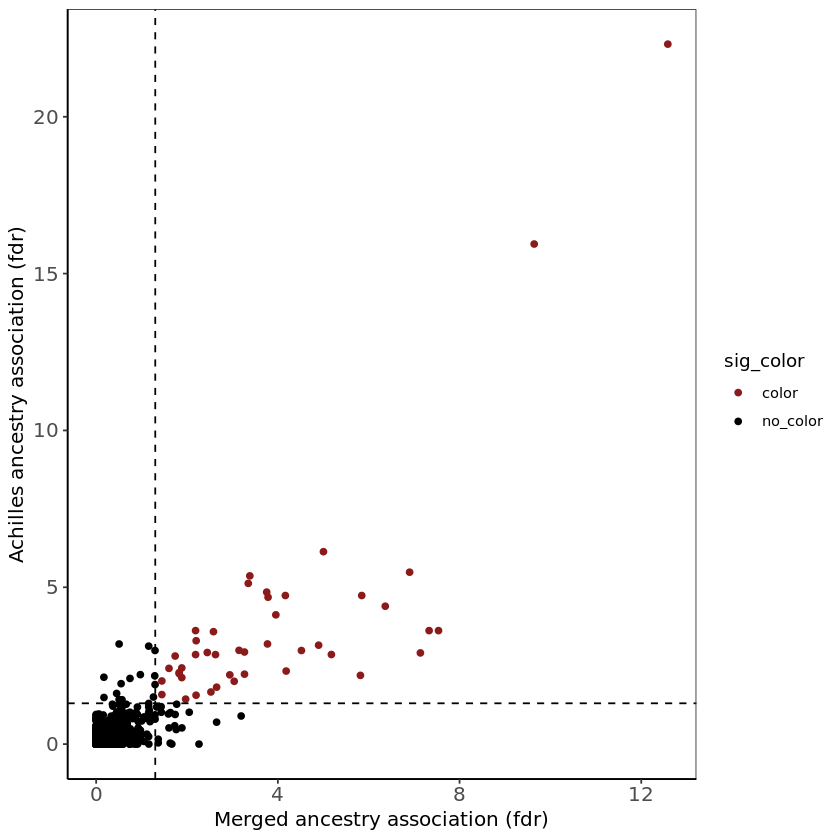

In [14]:
#Correlate the p-values from the achilles only and the merged
merged.pval.matrix %>%
mutate("sig_color" = ifelse(achilles_fdr < 0.05 & merged_fdr < 0.05, "color", "no_color")) %>%
ggplot(aes(x = -log10(merged_fdr), y = -log10(achilles_fdr), color = sig_color)) +
geom_point() +

geom_hline(yintercept = 1.301, linetype = 2) +
geom_vline(xintercept = 1.301, linetype = 2) +

scale_color_manual(values = c("firebrick4", "black")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +


ylab("Achilles ancestry association (fdr)") +
xlab("Merged ancestry association (fdr)")


#Export it to the google bucket
setwd('../output')
ggsave("supplemental_fig1.pdf", width = 5, height = 4)

In [16]:
#Write the table for making the figure
df_for_sf1 = merged.pval.matrix %>%
mutate("sig_color" = ifelse(achilles_fdr < 0.05 & merged_fdr < 0.05, "color", "no_color"))

setwd("../output")
write.table(df_for_sf1, "supplemental_figure1_data_table.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [15]:
#Calculate the total number of significant genes in each dataset
merged.pval.matrix %>% filter(achilles_fdr < 0.05) %>% pull(achilles_gene) %>% unique() %>% length()
merged.pval.matrix %>% filter(merged_fdr < 0.05) %>% pull(merged_gene) %>% unique() %>% length()
merged.pval.matrix %>% filter(achilles_fdr < 0.05 & merged_fdr < 0.05) %>% pull(achilles_gene) %>% unique() %>% length()

[1] 46

[1] 49

[1] 34